In [1]:
print("Hello")

Hello


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)

# models
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

# persistence
import joblib

In [4]:
RANDOM_STATE = 42

# %% [markdown]
# 1) Load data

# Update the path below if your file lives elsewhere. The uploaded file was "loan_prediction.csv.xlsx" in /mnt/data.

# %%
data_path_xlsx = 'loan_prediction.csv.xlsx'

if os.path.exists(data_path_xlsx):
    df = pd.read_excel(data_path_xlsx)
else:
    # common fallback: CSV with similar name
    csv_path = '/mnt/data/loan_prediction.csv'
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        raise FileNotFoundError(f"Could not find dataset at {data_path_xlsx} or {csv_path}")

print('Data shape:', df.shape)
df.head()

Data shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
print('\n--- INFO ---')
df.info()

print('\n--- DESCRIBE (numerical) ---')
print(df.describe().T)

# %%
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print('\n--- Missing values ---')
print(missing[missing>0])


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB

--- DESCRIBE (numerical) ---
                   count         mean          std    min     25%   


Loan_Status value counts:
Loan_Status
Y    422
N    192
Name: count, dtype: int64

Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


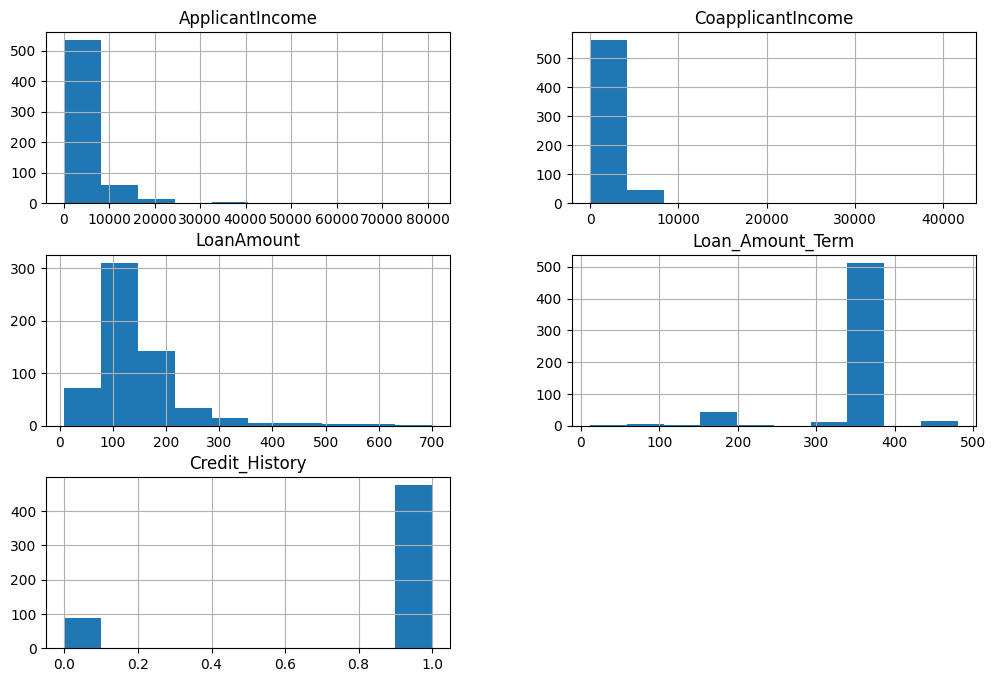

In [6]:
if 'Loan_Status' in df.columns:
    print('\nLoan_Status value counts:')
    print(df['Loan_Status'].value_counts())

# %% [markdown]
# 3) Quick visual EDA (distributions / bivariate checks)

# %%
# Histograms for numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Loan_Status' in num_cols:
    num_cols.remove('Loan_Status')

_ = df[num_cols].hist(figsize=(12, 8))

# %%
# Barplots for categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print('\nCategorical columns:', cat_cols)

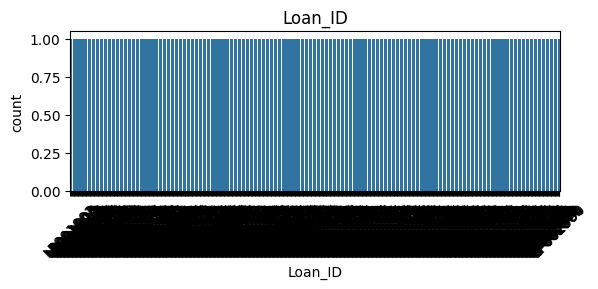

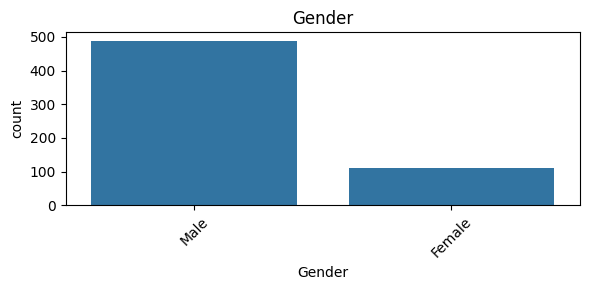

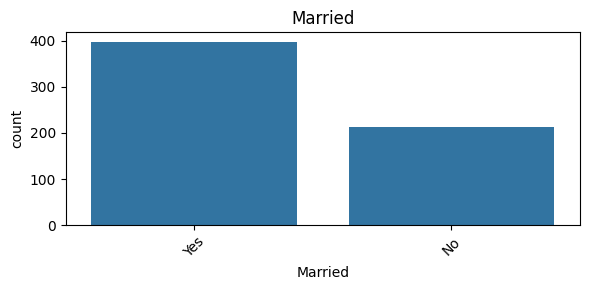

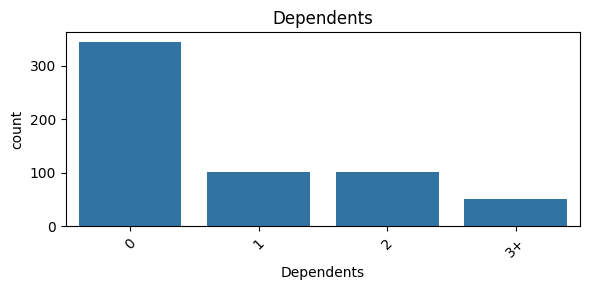

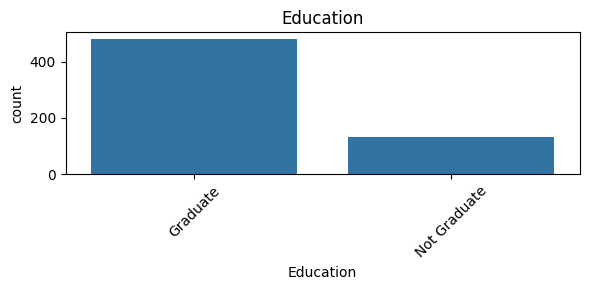

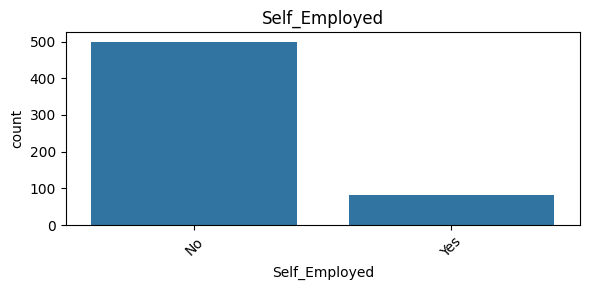

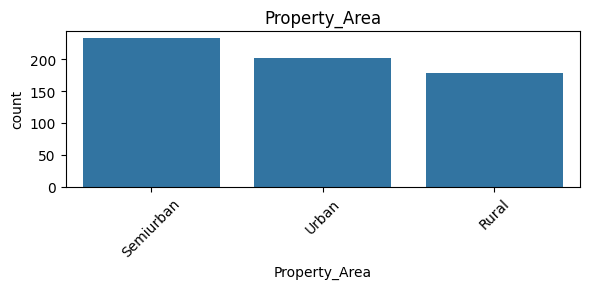

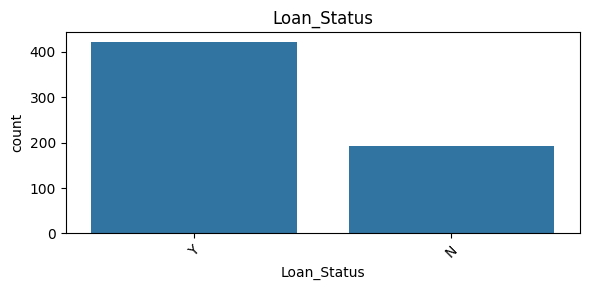

In [7]:
for c in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df, x=c, order=df[c].value_counts().index)
    plt.title(c)
    plt.xticks(rotation=45)
    plt.tight_layout()

In [8]:
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])

# Convert target
if 'Loan_Status' in df.columns:
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# quick look at cleaned head
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


Training RandomForest baseline...
--- RandomForest Evaluation ---
              precision    recall  f1-score   support

           0       0.76      0.58      0.66        38
           1       0.83      0.92      0.87        85

    accuracy                           0.81       123
   macro avg       0.79      0.75      0.76       123
weighted avg       0.81      0.81      0.81       123



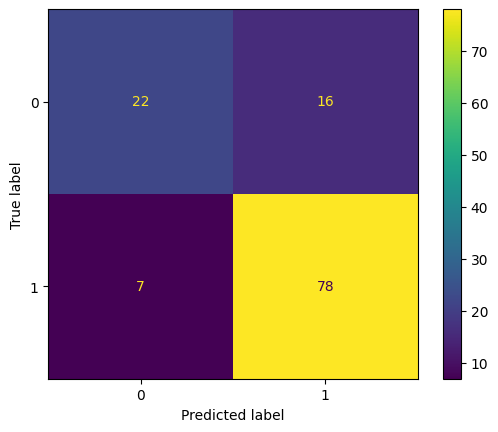


Training XGBoost...
--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        38
           1       0.84      0.87      0.86        85

    accuracy                           0.80       123
   macro avg       0.76      0.75      0.76       123
weighted avg       0.79      0.80      0.79       123



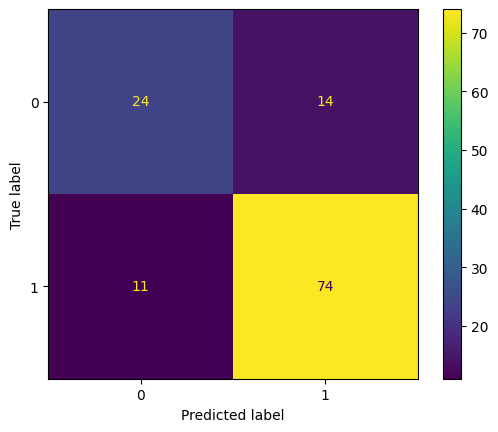

Cross-val RandomForest: [0.78861789 0.78861789 0.77235772 0.73170732 0.78688525]
Cross-val XGBoost: [0.76422764 0.77235772 0.75609756 0.71544715 0.75409836]


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None

RANDOM_STATE = 42

# Load data
data_path_xlsx = 'loan_prediction.csv.xlsx'
if os.path.exists(data_path_xlsx):
    df = pd.read_excel(data_path_xlsx)

# Drop ID and map target
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])
if 'Loan_Status' in df.columns:
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Drop rows where target is NaN
df = df.dropna(subset=['Loan_Status'])

# Ensure all categorical columns are strings to avoid mixed types
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)

X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Treat all categorical features (binary + multi-class) via OneHotEncoder in CV to avoid float conversion errors
cat_pipeline = Pipeline(steps=[('imputer', cat_imputer), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_pipeline = Pipeline(steps=[('imputer', num_imputer), ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, cat_features)
])

rf_pipeline = Pipeline(steps=[('preproc', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])
if XGBClassifier is not None:
    xgb_pipeline = Pipeline(steps=[('preproc', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))])
else:
    xgb_pipeline = rf_pipeline

def evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name='model'):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    try:
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    except:
        y_proba = None
    print(f"--- {model_name} Evaluation ---")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

print('Training RandomForest baseline...')
rfscores = evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test, 'RandomForest')

if XGBClassifier is not None:
    print('\nTraining XGBoost...')
    xgbscores = evaluate_model(xgb_pipeline, X_train, y_train, X_test, y_test, 'XGBoost')

# Cross-validation using pipelines so all preprocessing happens inside folds
print('Cross-val RandomForest:', cross_val_score(rf_pipeline, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='accuracy'))
if XGBClassifier is not None:
    print('Cross-val XGBoost:', cross_val_score(xgb_pipeline, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='accuracy'))
